## 1 モジュールの準備

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, RandomAffine
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from tqdm import tqdm


## 2 データの準備

### 2.1 訓練データの取得、設定

In [2]:
# データを格納するリスト
X = []
Z = []

# 画像のサイズ
IMG_SIZE = 150

# 各花のディレクトリのパス
FLOWER_DAISY_DIR = '../input/flowers/daisy'
FLOWER_DANDI_DIR = '../input/flowers/dandelion'
FLOWER_ROSE_DIR = '../input/flowers/rose'
FLOWER_SUNFLOWER_DIR = '../input/flowers/sunflower'
FLOWER_TULIP_DIR = '../input/flowers/tulip'

# フラグを初期化
added_flowers = set()


次のmake_tarin_data関数は、データセットから花の画像を読み込んでデータを準備するためのものです。

- `flower_type`: 花の種類を指定します。
- `DIR`: 花の画像が格納されているディレクトリのパスです。

この関数は、各花のデータを一度だけデータリストに追加し、重複を防ぐために役立ちます。関数内で、`added_flowers`というセットを使用して、すでにデータが追加された花の種類を追跡します。同じ花のデータが複数回追加されるのを防ぐため、各花のデータを追加する前に、その花の種類が`added_flowers`セットに存在しないかを確認します。花の種類がまだ追加されていない場合にのみデータを追加します。


In [3]:
# データの格納とコメントを追加した関数
def make_train_data(flower_type, DIR):
    if flower_type not in added_flowers:
        added_flowers.add(flower_type)
        # 各花のデータを格納するためのループ
        for img in tqdm(os.listdir(DIR)):
            # ラベルを花の名前に設定
            label = str(flower_type)
            # 画像ファイルのパスを生成
            path = os.path.join(DIR, img)
            # 画像をカラーで読み込み
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            # 画像サイズをリサイズ
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # データをリストに追加
            X.append(np.array(img))
            Z.append(str(label))


In [4]:
# 各花に対してデータを作成
make_train_data('Daisy', FLOWER_DAISY_DIR)
make_train_data('Dandelion', FLOWER_DANDI_DIR)
make_train_data('Rose', FLOWER_ROSE_DIR)
make_train_data('Sunflower', FLOWER_SUNFLOWER_DIR)
make_train_data('Tulip', FLOWER_TULIP_DIR)

# データの長さを出力
print(len(X))


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 984/984 [00:08<00:00, 115.73it/s]

4317


### 2.2 ランダムなデータの表示

このコードは、データセットからランダムに選択された9つの花の画像を3x3のグリッドに表示します。各画像には花の名前がタイトルとして表示され、データセットの内容を視覚化します。ランダムなサンプルを表示することで、データの内容を素早く把握できます。


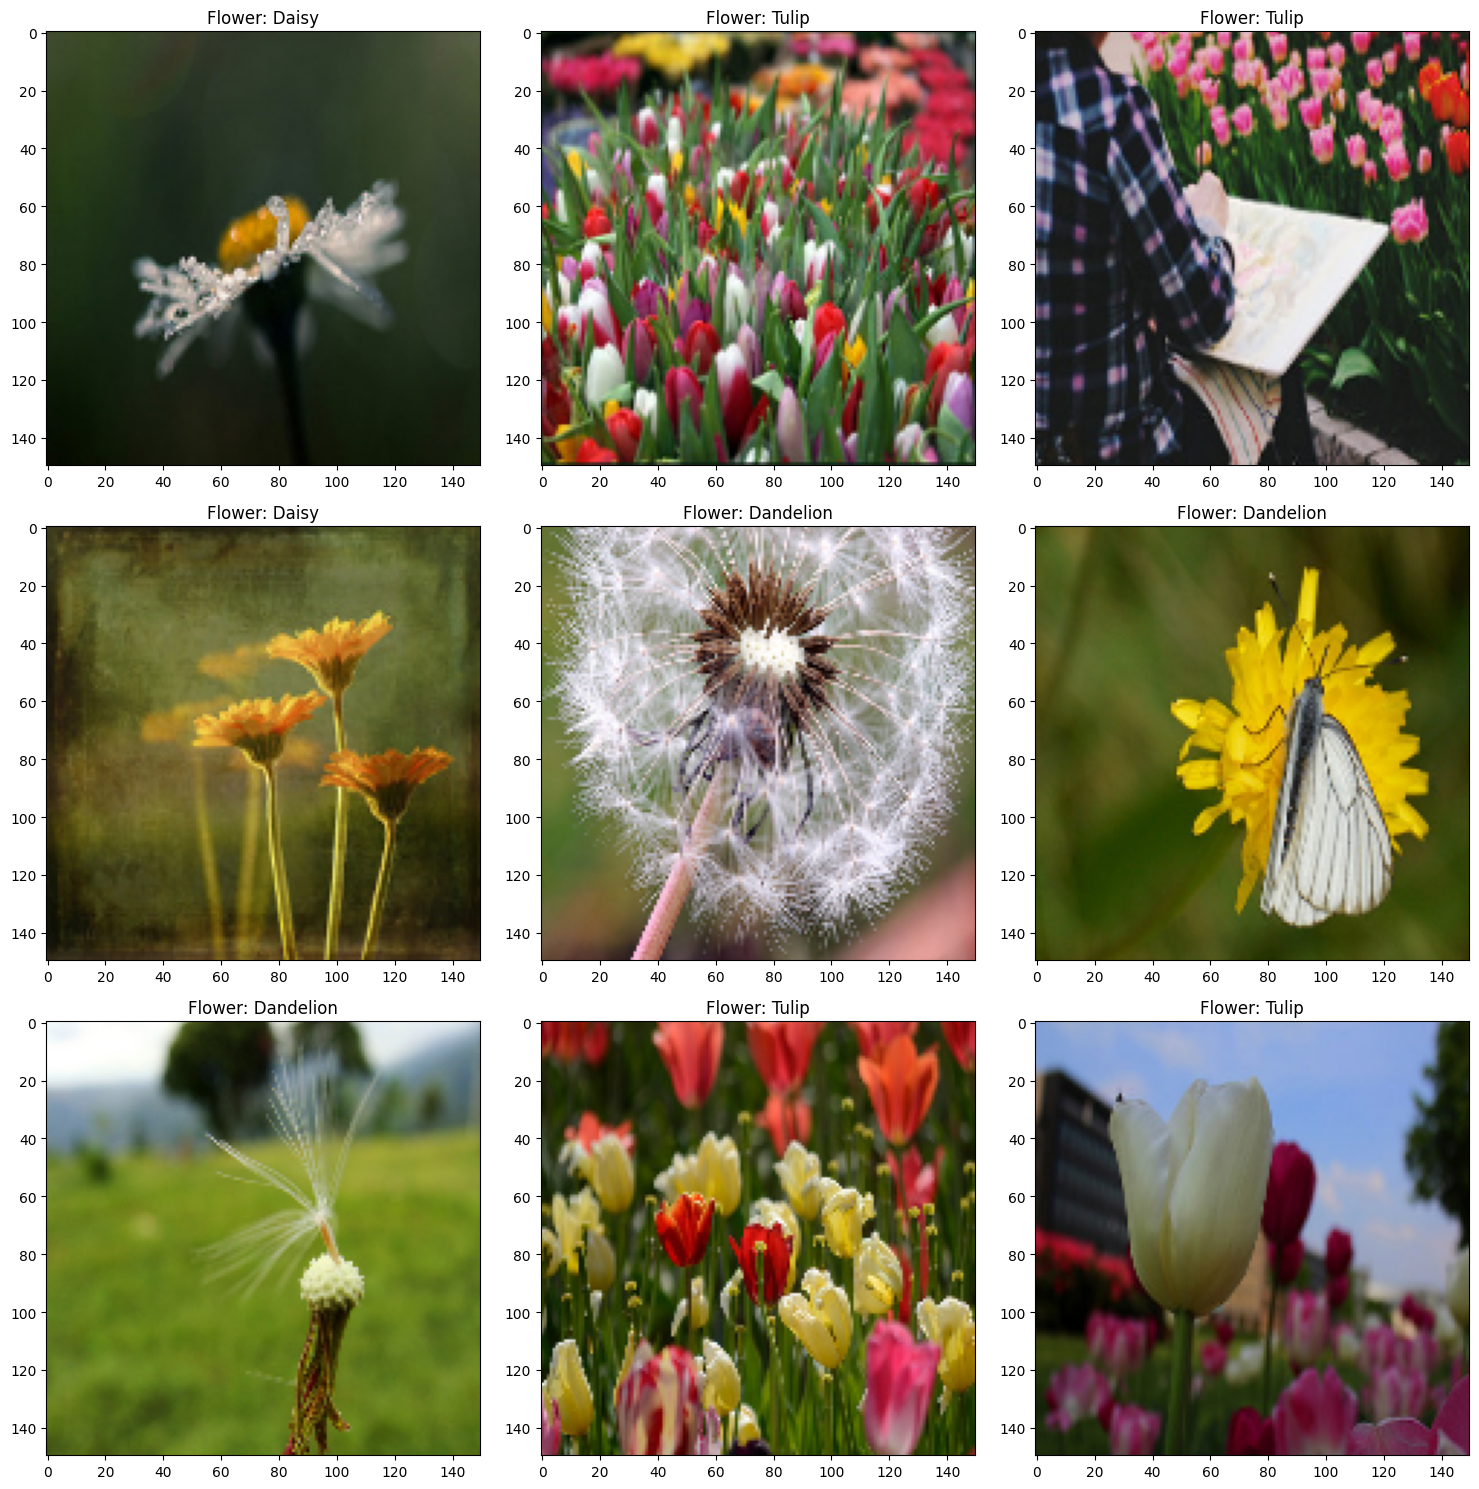

In [5]:
# 3x3のサブプロットを作成
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

# 9つのランダムな画像を選択して表示
for i in range(3):
    for j in range(3):
        # ランダムにインデックスを選択
        random_index = random.randint(0, len(Z) - 1)
        
        # 画像をRGB形式に変換
        img_rgb = cv2.cvtColor(X[random_index], cv2.COLOR_BGR2RGB)
        
        # サブプロットに画像を表示
        ax[i, j].imshow(img_rgb)
        
        # タイトルに花の種類を表示
        ax[i, j].set_title('Flower: ' + Z[random_index])

# グラフを整えて表示
plt.tight_layout()
plt.show()


## ラベルのエンコードとワンホットエンコード

### ラベルのエンコード（Label Encoding）
- カテゴリカルデータを整数のラベルに変換する手法です。
- 例: "Daisy"を0、"Rose"を1、"Tulip"を2に変換します。
- 機械学習アルゴリズムが数値データを理解できるようにするために使用されます。

### ワンホットエンコード（One Hot Encoding）
- カテゴリカルデータをバイナリベクトルに変換する手法です。
- 各カテゴリは新しい特徴量（列）に変換され、該当する列に1が立ち、他の列には0が入ります。
- 例: "Daisy"は[1, 0, 0]、"Rose"は[0, 1, 0]、"Tulip"は[0, 0, 1]に変換されます。
- カテゴリ情報を表現し、順序や距離を導入せずにカテゴリカルデータを処理するために使用されます。


In [74]:
# LabelEncoderを使って、Zを数値にエンコード
le = LabelEncoder()
Y = le.fit_transform(Z)

# PyTorchのnn.functional.one_hotを使って、ワンホットエンコーディングを適用
Y = torch.tensor(Y, dtype=torch.long)

# XをPyTorchのTensorに変換し、0から1の範囲に正規化
X = torch.tensor(X, dtype=torch.float32)
X = X / 255

# XとYを出力（必要に応じて）
print(X)
print(Y)


/tmp/ipykernel_12852/3390689573.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


: 

: 

### データの分割
訓練データとテストデータに分けます

In [7]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


### シード値の決定

In [63]:
# 乱数シードを設定
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# GPUを使用する場合、以下の設定も行うことがあります
torch.backends.cudnn.deterministic = True  # cudnnを再現可能モードに設定
torch.backends.cudnn.benchmark = False     # cudnnのベンチマークを無効にする


## モデルの作成

In [64]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 最初の畳み込み層：32フィルタ、5x5カーネル、ReLU活性化関数、入力チャネルは3（RGB）
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding='same')
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 二番目の畳み込み層：64フィルタ、3x3カーネル、ReLU活性化関数
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 三番目の畳み込み層：96フィルタ、3x3カーネル、ReLU活性化関数
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding='same')
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 四番目の畳み込み層：96フィルタ、3x3カーネル、ReLU活性化関数
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, padding='same')
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten層
        self.flatten = nn.Flatten()

        # 全結合層
        self.fc1 = nn.Linear(96 * 9 * 9, 512)  # 96フィルタ、9x9サイズ（入力サイズに依存）
        self.relu5 = nn.ReLU()

        # 出力層：5クラスに分類するための層
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.fc2(x)
        return x


### 学習率を段階的に下げる方法の使用

In [65]:
batch_size=128
epochs=50

# GPUが利用可能かどうかを確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルをデバイスに移動
model = SimpleCNN().to(device)

# オプティマイザーの定義（例: Adam）
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 学習率アニーラーの設定
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)


### データ拡張

In [66]:
# データ拡張の設定
data_transforms = transforms.Compose([
    transforms.ToPILImage(),  # NumPy配列をPIL画像に変換
    RandomRotation(10),  # ランダムに画像を回転（0から10度）
    RandomAffine(degrees=0, scale=(0.9, 1.1)),  # ランダムに画像をズーム（0.1の範囲で）
    RandomAffine(degrees=0, translate=(0.2, 0)),  # ランダムに画像を水平方向にシフト（最大20%）
    RandomAffine(degrees=0, translate=(0, 0.2)),  # ランダムに画像を垂直方向にシフト（最大20%）
    RandomHorizontalFlip(),  # ランダムに画像を水平方向に反転
    transforms.ToTensor()  # PIL画像をテンソルに変換し、チャネル次元を再配置
])


In [67]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()


In [68]:
if torch.cuda.is_available():
    model.to('cuda')  # モデルをGPUに移動
summary(model, input_size=(3, 150, 150))
  # input_sizeはモデルの入力チャネル数と画像サイズに合わせて指定


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]           2,432
              ReLU-2         [-1, 32, 150, 150]               0
         MaxPool2d-3           [-1, 32, 75, 75]               0
            Conv2d-4           [-1, 64, 75, 75]          18,496
              ReLU-5           [-1, 64, 75, 75]               0
         MaxPool2d-6           [-1, 64, 37, 37]               0
            Conv2d-7           [-1, 96, 37, 37]          55,392
              ReLU-8           [-1, 96, 37, 37]               0
         MaxPool2d-9           [-1, 96, 18, 18]               0
           Conv2d-10           [-1, 96, 18, 18]          83,040
             ReLU-11           [-1, 96, 18, 18]               0
        MaxPool2d-12             [-1, 96, 9, 9]               0
          Flatten-13                 [-1, 7776]               0
           Linear-14                  [

### データローダー

In [69]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # 画像データの形状を[チャネル数, 高さ, 幅]に変換
        image = image.permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        # データをデバイスに移動
        return image.to(device), label.to(device)

# データ拡張の定義
data_transforms = transforms.Compose([
    # 画像データがテンソルの場合はToPILImageは不要
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    # その他の変換を追加...
])

# データローダーの設定
train_dataset = CustomDataset(x_train, y_train, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(x_test, y_test, transform=None)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [70]:
# トレーニングデータセットとデータローダー
train_dataset = CustomDataset(x_train, y_train, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 検証データセットとデータローダー
val_dataset = CustomDataset(x_test, y_test, transform=transforms.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [71]:
# 損失と精度を記録するためのリスト
train_losses = []
val_losses = []
val_accuracies = []

# トレーニングループ
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    # tqdmを使用して進捗状況を表示
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, '
          f'Validation Loss: {val_losses[-1]}, '
          f'Validation Accuracy: {val_accuracies[-1]}%')


RuntimeError: Expected floating point type for target with class probabilities, got Long

In [73]:
print(y_train[0])


tensor([0, 1, 0, 0, 0])


In [ ]:
print(type(x_train))


<class 'torch.Tensor'>


In [ ]:
torch.__version__


'2.1.1+cu121'